## Setup

In [150]:
import sklearn
import pandas as pd
import numpy as np
from sklearn.datasets import make_friedman1
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import sys
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [145]:
# Fill in the path where you downloaded the project or if the hole folder is open, leave it as it is. 
# Should print what in your folder is.
ROOT_PATH = '.' # Replace with A3 directory path
print(os.listdir(ROOT_PATH))

['.git', 'gen_dataset.ipynb', 'README.md', 'requirements_local.txt', 'Simulaiton1_Nadja.ipynb', 'test.ipynb', 'tree.dot', 'utils.py']


In [146]:
from utils import generate_friedman1, to_dataframe, plot_data_3D, train_test_stratified, evaluate_rf

## Generate Friedman1 dataset

In [147]:
features, y = generate_friedman1()
(features, y)

(array([[0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864],
        [0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258],
        [0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497],
        ...,
        [0.44278322, 0.57820664, 0.46877158, 0.14188158, 0.74118443],
        [0.53303816, 0.39932288, 0.5596385 , 0.24122695, 0.42795772],
        [0.6224452 , 0.22619357, 0.74899508, 0.52101091, 0.86170671]]),
 array([16.83826156, 12.51782504,  5.86968919, ..., 12.34777254,
        10.8228707 , 15.03893816]))

In [10]:
df=to_dataframe(features=features, y=y)
df

,X1,X2,X3,X4,X5,y
0,0.374540,0.950714,0.731994,0.598658,0.156019,16.838262
1,0.155995,0.058084,0.866176,0.601115,0.708073,12.517825
2,0.020584,0.969910,0.832443,0.212339,0.181825,5.869689
3,0.183405,0.304242,0.524756,0.431945,0.291229,7.531879
4,0.611853,0.139494,0.292145,0.366362,0.456070,9.457372
...,...,...,...,...,...,...
9995,0.532481,0.550056,0.984144,0.599966,0.666627,21.977669
9996,0.213723,0.106865,0.602010,0.864880,0.587373,12.510693
9997,0.442783,0.578207,0.468772,0.141882,0.741184,12.347773
9998,0.533038,0.399323,0.559639,0.241227,0.427958,10.822871


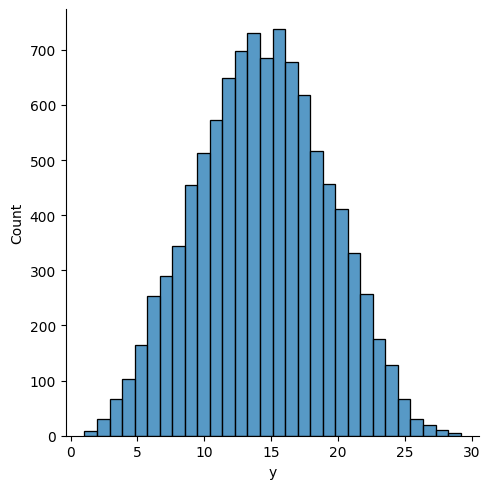

In [11]:
sns.displot(df, x='y', bins = 30)

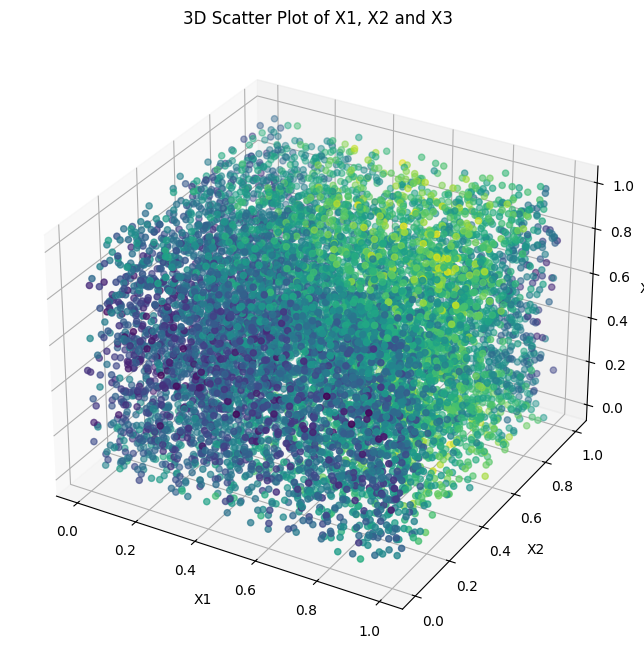

In [132]:
plot_data_3D(df, ['X3', 'X4','X5'])

### What if we add noise??

In [151]:
features_noise, y_noise = generate_friedman1(noise=10)
df_noise=to_dataframe(features_noise, y_noise)
df_noise

,X1,X2,X3,X4,X5,y
0,0.374540,0.950714,0.731994,0.598658,0.156019,16.647628
1,0.155995,0.058084,0.866176,0.601115,0.708073,24.590708
2,0.020584,0.969910,0.832443,0.212339,0.181825,12.122614
3,0.183405,0.304242,0.524756,0.431945,0.291229,-0.515011
4,0.611853,0.139494,0.292145,0.366362,0.456070,27.328506
...,...,...,...,...,...,...
9995,0.532481,0.550056,0.984144,0.599966,0.666627,28.648759
9996,0.213723,0.106865,0.602010,0.864880,0.587373,8.005824
9997,0.442783,0.578207,0.468772,0.141882,0.741184,29.699039
9998,0.533038,0.399323,0.559639,0.241227,0.427958,-1.211299


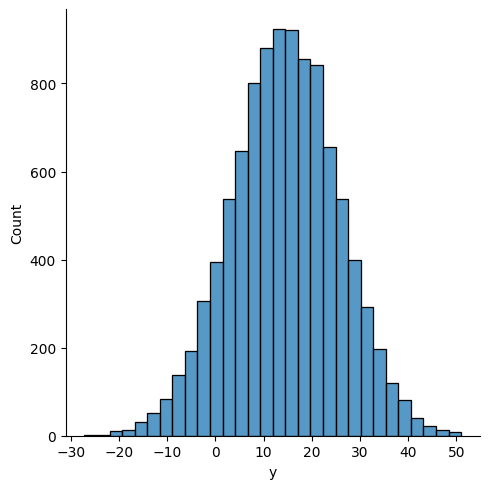

In [67]:
sns.displot(df_noise, x='y', bins = 30)

-> It doesn't really make it imbalanced, but standard deviation becomes larger.

## Random Forest, no stratification, 5-fold cv, random search

In [17]:
# first devide data in train/test data (80/20 ratio)
X_train, X_test, y_train, y_test = train_test_split(df.iloc[: , :-1], df['y'], test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [116]:
# Define the parameter grid for random search
param_rf = {
    'n_estimators': np.arange(500, 1001),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': np.arange(1, X_train.shape[1] + 1)
}

In [117]:
# Initialize Random Forest model
rf_model=RandomForestRegressor(random_state=42)
                            

In [118]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_rf,
                                   n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)


In [29]:
# Perform the random search on the training set
random_search.fit(X_train, y_train)

# Display the best parameters found by random search
print("Best Parameters:", random_search.best_params_)


Best Parameters: {'n_estimators': 882, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4}


In [30]:
# Display the cross-validated score with the best parameters
best_score = random_search.best_score_
print(f"\nBest Cross-Validated Mean Squared Error: {best_score:.4f}")



Best Cross-Validated Mean Squared Error: -1.5476


In [33]:
# Evaluate the model with the best parameters on the test set
best_model = random_search.best_estimator_
train_score=best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)
print(f"Train Set R^2 Score: {train_score:.4f} \nTest Set R^2 Score: {test_score:.4f}")

Train Set R^2 Score: 0.9671 
Test Set R^2 Score: 0.9341


## Random Forest, Stratification, 5-fold cv, random search

@Anne: why create data agian? Use on same one

In [96]:
features, y = generate_friedman1(n_samples=10000)
df=to_dataframe(features=features, y=y)

In [99]:
np.histogram(df['y'], bins='doane')  

(array([  39,  168,  417,  633,  968, 1221, 1428, 1422, 1294,  974,  744,
         432,  194,   50,   16], dtype=int64),
 array([ 1.04236923,  2.91850644,  4.79464365,  6.67078086,  8.54691807,
        10.42305528, 12.29919249, 14.1753297 , 16.05146691, 17.92760412,
        19.80374133, 21.67987854, 23.55601575, 25.43215296, 27.30829017,
        29.18442738]))

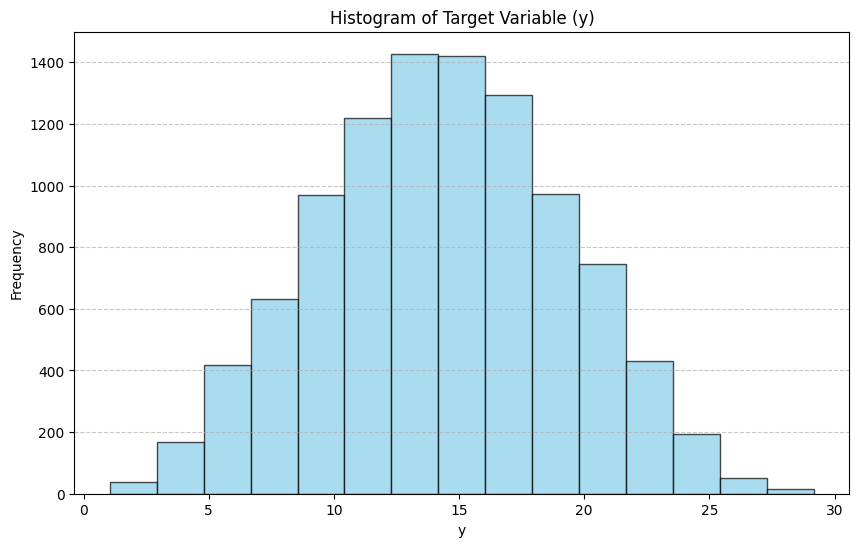

In [100]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['y'], bins='doane', color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Target Variable (y)')
plt.xlabel('y')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

Approach with quantiles. In this case with 20 5% quantiles to sample randomly 80% from each one. 

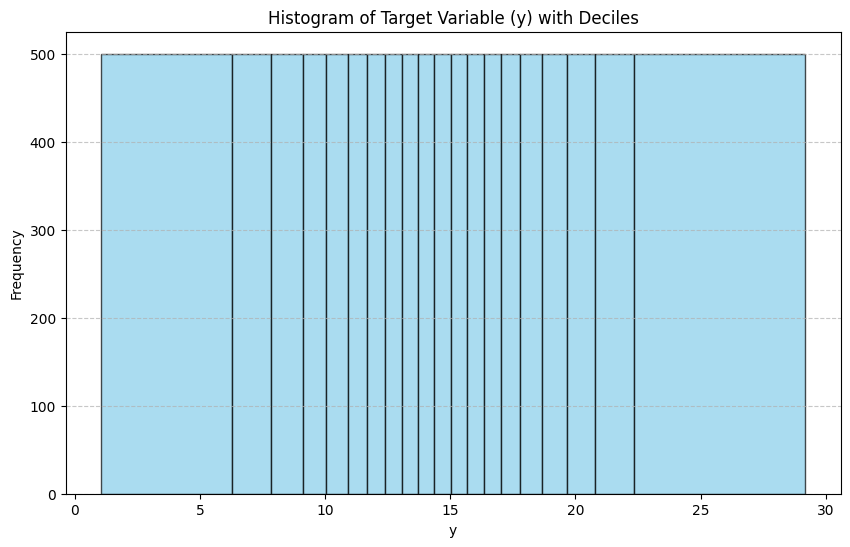

In [101]:
# Calculate decile values
quantiles = [np.percentile(df['y'], i) for i in range(0, 101, 5)]

# Plot the histogram with decile values
plt.figure(figsize=(10, 6))
plt.hist(df['y'], bins=quantiles, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Target Variable (y) with Deciles')
plt.xlabel('y')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

In [160]:
X_train, X_test, y_train, y_test = train_test_stratified(df=df)

In [162]:
# Verify the sizes of the train and test sets
print("Train set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)

Train set size: (8000, 5) (8000,)
Test set size: (2000, 5) (2000,)


@Anne: initalize random search, I think otherwise continue training old random search model ?

In [120]:
# Perform the random search on the training set
random_search.fit(X_train, y_train)

# Display the best parameters found by random search
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'n_estimators': 882, 'min_samples_split': 14, 'min_samples_leaf': 8, 'max_features': 4}


In [121]:
# Display the cross-validated score with the best parameters
best_score = random_search.best_score_
print(f"\nBest Cross-Validated Mean Squared Error: {best_score:.4f}")


Best Cross-Validated Mean Squared Error: -8.2865


In [131]:
# Evaluate the model with the best parameters on the test set
best_model = random_search.best_estimator_
train_score=best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)
print(f"Train Set R^2 Score: {train_score:.4f} \nTest Set R^2 Score: {test_score:.4f}")

Train Set R^2 Score: 0.9664 
Test Set R^2 Score: 0.9401


In [169]:
test = evaluate_rf(model=random_search, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

Train Set R^2 Score: 0.9664 
Test Set R^2 Score: 0.9401 
 Train Set MSE Score: 0.7954 
Test Set MSE Score: 1.4216


In [170]:
test

{'train r2': 0.9664043809065394,
 'test r2': 0.9400934706767345,
 'train mse': 0.7954050226814497,
 'test mse': 1.4215717093507307}

## Try without cross validation

In [126]:
rf_baseline=RandomForestRegressor(n_estimators=882, min_samples_split=14, min_samples_leaf=8, max_features=4, random_state=42)

In [127]:
rf_baseline.fit(train_data.drop(columns=['y']), train_data['y'])

RandomForestRegressor(max_features=4, min_samples_leaf=8, min_samples_split=14,
                      n_estimators=882, random_state=42)

In [134]:
# Evaluate the model with the best parameters on the test set
train_score_base=rf_baseline.score(train_data.drop(columns=['y']), train_data['y'])
test_score_base = rf_baseline.score(test_data.drop(columns=['y']), test_data['y'])
print(f"Train Set R^2 Score: {train_score_base:.4f} \nTest Set R^2 Score: {test_score_base:.4f}")

Train Set R^2 Score: 0.9664 
Test Set R^2 Score: 0.9401
